<a href="https://colab.research.google.com/github/dkim319/Twitter_Sentiment_Analysis/blob/master/3_NLP_Sentiment_Text_Analysis_Transfer_Learning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - Transfer Learning

## Introduction

This notebook covers the building of a transfer learning model for Twitter sentiment analysis of the NLTK Twitter samples as a dataset.



## 1. Setup

All required libraries are loaded and the Tensorflow version is checked.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
# !pip install -q tensorflow-datasets
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
import os
from os import getcwd
import matplotlib.pyplot as plt

import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

print(tf.__version__)

2.3.0


The NLTK Twitter dataset is loaded.

In [ ]:
# add folder, tmp2, from our local workspace containing pre-downloaded corpora files to nltk's data path
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)

nltk.download('stopwords')
nltk.download('twitter_samples')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

## 2. Prep Data for Deep Learning

The data is split into the training and test datasets (features and labels) and tweets are cleaned up.

In [ ]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    #stemmer = PorterStemmer()
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    tweet = tweet.lower()
    # tokenize tweets

    return tweet

In [ ]:
# get the sets of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

train_x_cleaned = []
test_x_cleaned = []

for i, val in enumerate(train_x): 
   train_x_cleaned.append(process_tweet(train_x[i]))
  
for i, val in enumerate(test_x): 
   test_x_cleaned.append(process_tweet(test_x[i]))  

train_x_np = np.array(train_x_cleaned)
test_x_np = np.array(test_x_cleaned)

# avoid assumptions about the length of all_positive_tweets
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

The original and cleaned tweets are reviewed.

In [ ]:
train_x[2]

'@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!'

In [ ]:
train_x_np[2]

' we had a listen last night :) as you bleed is an amazing track. when are you in scotland?!'

## 3. Build the Model

The transfer learning model leverages Google's pre-trained text embedding model based on Google New 7B corpus.  This is the link to embedding: https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1

The first step is to configure the KerasLayer to load in this pre-train text embedding.

In [ ]:
"""
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)

embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
hub_layer = hub.KerasLayer(embedding, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)
"""

embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
hub_layer = hub.KerasLayer(embedding, output_shape=[50], input_shape=[], 
                           dtype=tf.string, trainable=True)

hub_layer(train_x_np[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.18177961,  0.30905282, -0.0955687 , -0.02481533,  0.07251601,
         0.09626536,  0.06276587, -0.02867672,  0.03171784, -0.06458392,
         0.12174236,  0.07538073,  0.1094935 , -0.10432209,  0.2389291 ,
        -0.01256077, -0.15951258, -0.03723193,  0.0015762 , -0.10129286,
        -0.10726307,  0.03916125,  0.16474564, -0.07280651, -0.02297282,
         0.16508304, -0.50607455,  0.12797995,  0.11485224,  0.02898668,
        -0.00376796, -0.03540844,  0.00164975, -0.08325573, -0.20080048,
        -0.03544626,  0.19501816,  0.11686108,  0.02408622,  0.0222721 ,
         0.28063452,  0.15775855, -0.14600493,  0.17744695,  0.04100045,
        -0.19509828,  0.0950956 , -0.2723935 ,  0.14293464,  0.11286461],
       [ 0.1751235 ,  0.0196493 , -0.31946498,  0.2754337 ,  0.05172827,
         0.09370855,  0.12976623, -0.1156506 , -0.30690724,  0.23473029,
        -0.10742051,  0.19808711,  0.16013856,  0.17970525, -0.09471116,
 

The next step is to configure a DNN model that takes in the pre-trained embedding and two more layers to ensure that the model produces the expected output.

In [ ]:
# set the seed and clear session to ensure consistent results and avoid past models impacting the current model
tf.keras.backend.clear_session()
tf.random.set_seed(319)
np.random.seed(319)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


The model is compiled.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

The model produced a training accuracy of 97.1% after only 10 epochs.  This is the best performing model out of the three attempted.  



In [ ]:
history = model.fit(train_x_np,
                    train_y,
                    epochs=20,
                    #batch_size=512,
                    validation_data=(test_x_np,test_y),
                    verbose=1)

Epoch 1/20
250/250 [==============================] - 4s 15ms/step - loss: 0.0010 - accuracy: 0.9995 - val_loss: 0.1088 - val_accuracy: 0.9710
Epoch 2/20
250/250 [==============================] - 4s 15ms/step - loss: 9.5840e-04 - accuracy: 0.9998 - val_loss: 0.1096 - val_accuracy: 0.9680
Epoch 3/20
250/250 [==============================] - 4s 15ms/step - loss: 9.8402e-04 - accuracy: 0.9996 - val_loss: 0.1124 - val_accuracy: 0.9675
Epoch 4/20
250/250 [==============================] - 4s 15ms/step - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.1134 - val_accuracy: 0.9680
Epoch 5/20
250/250 [==============================] - 4s 15ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.1120 - val_accuracy: 0.9690
Epoch 6/20
250/250 [==============================] - 4s 15ms/step - loss: 9.4586e-04 - accuracy: 0.9996 - val_loss: 0.1144 - val_accuracy: 0.9690
Epoch 7/20
250/250 [==============================] - 4s 15ms/step - loss: 9.9729e-04 - accuracy: 0.9996 - val_loss: 0.1167 - val_

The chart function is created for plotting the accuracy and loss.

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)''
  plt.legend([string, 'val_'+string])
  plt.show()

The accuracy and loss charts show that even after 1 epoch, the transfer learning model was able to produce a model with great validation accuracy.

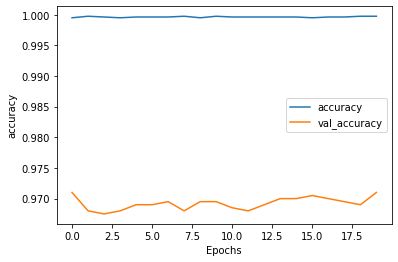

In [ ]:
plot_graphs(history, 'accuracy')

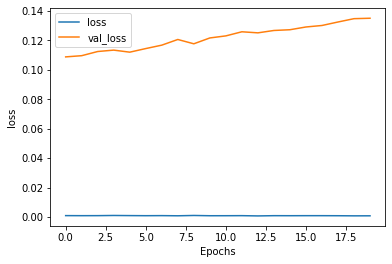

In [ ]:
plot_graphs(history, 'loss')

## Conclusion

The transfer learning model performed the best with a validation accuracy of 97.1% compared to the other two approaches.  The initial training dataset did not have enough data to produced a high performing model.  Tranfer learning was the best solution for these types of situations.   